In [ ]:
!nvidia-smi

Tue Aug 25 05:49:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!git clone https://github.com/NVIDIA/apex /apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /apex/.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/SSD/"
gdrive_dir = "/content/gdrive/My Drive/lab/SSD/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
models			 train-eval-sddLite.ipynb    trainval.zip
train-eval-sddEff.ipynb  train_eval_sddLiteV2.ipynb


In [3]:
!unzip -q "/content/gdrive/My Drive/lab/SSD/trainval.zip" -d /content
!git clone https://github.com/ncthuan/single-shot-detection-pytorch
!cp -r single-shot-detection-pytorch/. .
!pip install albumentations==0.4.6 -q

Cloning into 'single-shot-detection-pytorch'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 197 (delta 115), reused 130 (delta 52), pack-reused 0
Receiving objects: 100% (197/197), 203.78 KiB | 517.00 KiB/s, done.
Resolving deltas: 100% (115/115), done.
     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 952kB 8.8MB/s 


In [2]:
import os
import time
import torch
import torch.cuda as cuda
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from dataset import VOCDataset, collate_fn
from ssdEff import SSDEff
from loss import MultiBoxLoss
from utils import create_data_lists, clip_gradient, save_checkpoint
from eval_detection_voc import eval_detection_voc
device = torch.device("cuda" if cuda.is_available() else "cpu") 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

In [ ]:
from utils import create_data_lists
voc07_path = os.path.join('datasets/', 'VOC2007/')
voc12_path = os.path.join('datasets/', 'VOC2012/')
create_data_lists(voc07_path, voc12_path, output_folder='datasets/')

In [ ]:
!ls datasets/

In [3]:
torch.manual_seed(42)
trainset = VOCDataset(data_folder='datasets/', json_files=('TRAIN_images.json', 'TRAIN_objects.json'), augment=True, img_size=300)
valset = VOCDataset(data_folder='datasets/', json_files=('VAL_images.json', 'VAL_objects.json'), img_size=300)

dataloaders = dict(
    train = DataLoader(trainset, batch_size=32, collate_fn=collate_fn, shuffle=True, num_workers=2),
    val = DataLoader(valset, batch_size=32, collate_fn=collate_fn, shuffle=False, num_workers=2),
)

## Train model

In [ ]:
checkpoint = torch.load('../input/voc0712/pretrained_ssdeff.pt')
ssd_eff = checkpoint['model'].to(device)

ssd_eff.requires_grad_(False)
ssd_eff.lat_fm10.requires_grad_(True)
ssd_eff.lat_fm19.requires_grad_(True)
ssd_eff.final_fm19.requires_grad_(True)
ssd_eff.final_fm38.requires_grad_(True)
ssd_eff.det_fm38.requires_grad_(True)
ssd_eff.det_fm19.requires_grad_(True)
ssd_eff.det_fm10.requires_grad_(True)
ssd_eff.det_fm5.requires_grad_(True)
ssd_eff.det_fm3.requires_grad_(True)

In [22]:
checkpoint_path = gdrive_dir+'models/checkpoint_ssd_eff.pt'
checkpoint = torch.load(checkpoint_path) # None

if checkpoint:
    ssd_eff = checkpoint['model']
    optimizer = checkpoint['optimizer']
    #exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96, last_epoch=checkpoint['epoch']-1)
else:
    ssd_eff = SSDEff(n_classes=21).to(device)
    optimizer = torch.optim.Adam(ssd_eff.parameters(), lr=2e-3, weight_decay=5e-4)
    #exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

loss_func = MultiBoxLoss(priors_cxcy=ssd_eff.get_prior_boxes(), threshold=0.5, alpha=1., neg_pos_ratio=3, focal_loss=False)

grad_clip = None

In [5]:
def train_epoch(model, trainset_loader, loss_func, optimizer, epoch_id):
    model.train()
    train_loss = 0
    for step, (imgs, boxes, labels) in enumerate(trainset_loader):
        # move input data to GPU
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        # forward
        predicted_offsets, predicted_scores = model(imgs)
        loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
        
        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch_id == 1 and step % 50 == 0:
            print(f'Epoch 1 - step {step}: train_loss: {loss.item():.4f}')
        
        train_loss += loss.item()
        
    return round(train_loss/len(trainset_loader), 4)

def eval_epoch(model, valset_loader, loss_func):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for step, (imgs, boxes, labels) in enumerate(valset_loader):
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            
            predicted_offsets, predicted_scores = model(imgs)
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

    return round(val_loss/len(valset_loader), 4)


def train_model(model, dataloaders, optimizer, loss_func, lr_scheduler=None, n_epoch=1, checkpoint=None):
    last_epoch = 0
    if checkpoint:
        last_epoch = checkpoint['epoch']

    train_loss_hist, val_loss_hist = [], []
    for epoch_id in range(last_epoch+1, last_epoch+n_epoch+1):
        start_time = time.time()
        train_loss = train_epoch(model, dataloaders['train'], loss_func, optimizer, epoch_id)
        training_time = round(time.time() - start_time)
        if lr_scheduler: lr_scheduler.step()
        
        save_checkpoint(epoch_id, model, optimizer, checkpoint_path)
        
        # eval val_loss every epoch
        start_time = time.time()
        val_loss = eval_epoch(model, dataloaders['val'], loss_func) # if epoch_id % 5 == 0 else 'N/A'
        val_time = round(time.time() - start_time)
        
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        print(f'Epoch {epoch_id} - train/val_time: {training_time}s | {val_time}s - train_loss: {train_loss} - val_loss: {val_loss}')
        
    return train_loss_hist, val_loss_hist

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5)

Epoch 1 - step 0: train_loss: 4.1410
Epoch 1 - step 50: train_loss: 3.7223
Epoch 1 - step 100: train_loss: 3.2568
Epoch 1 - step 150: train_loss: 3.6013
Epoch 1 - step 200: train_loss: 3.4549
Epoch 1 - step 250: train_loss: 3.9920
Epoch 1 - step 300: train_loss: 4.2330
Epoch 1 - step 350: train_loss: 4.0177
Epoch 1 - step 400: train_loss: 3.6065
Epoch 1 - step 450: train_loss: 3.7743
Epoch 1 - step 500: train_loss: 3.7813
Epoch 1 - train/val_time: 355s | 53s - train_loss: 3.6877 - val_loss: 3.9226
Epoch 2 - train/val_time: 356s | 54s - train_loss: 3.6524 - val_loss: 3.856
Epoch 3 - train/val_time: 369s | 56s - train_loss: 3.6276 - val_loss: 3.9384
Epoch 4 - train/val_time: 390s | 59s - train_loss: 3.6472 - val_loss: 3.9306


In [ ]:
adjust_learning_rate(optimizer, lr=1.5e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=3, checkpoint=checkpoint)

Epoch 5 - train/val_time: 366s | 54s - train_loss: 3.2953 - val_loss: 3.5163
Epoch 6 - train/val_time: 359s | 54s - train_loss: 3.2467 - val_loss: 3.5558
Epoch 7 - train/val_time: 358s | 54s - train_loss: 3.2435 - val_loss: 3.5787


In [ ]:
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=8, checkpoint=checkpoint)

Epoch 8 - train/val_time: 364s | 54s - train_loss: 3.2603 - val_loss: 3.5154
Epoch 9 - train/val_time: 358s | 53s - train_loss: 3.2467 - val_loss: 3.6053
Epoch 10 - train/val_time: 359s | 54s - train_loss: 3.2605 - val_loss: 3.5952
Epoch 11 - train/val_time: 369s | 54s - train_loss: 3.274 - val_loss: 3.5628
Epoch 12 - train/val_time: 366s | 55s - train_loss: 3.2744 - val_loss: 3.5739
Epoch 13 - train/val_time: 372s | 56s - train_loss: 3.2553 - val_loss: 3.5515
Epoch 14 - train/val_time: 373s | 56s - train_loss: 3.2626 - val_loss: 3.5325
Epoch 15 - train/val_time: 373s | 56s - train_loss: 3.2638 - val_loss: 3.5201


In [ ]:
checkpoint = torch.load(checkpoint_path)
adjust_learning_rate(optimizer, lr=1.25e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 16 - train/val_time: 372s | 56s - train_loss: 3.0642 - val_loss: 3.3829
Epoch 17 - train/val_time: 373s | 55s - train_loss: 3.0831 - val_loss: 3.3407
Epoch 18 - train/val_time: 366s | 55s - train_loss: 3.0781 - val_loss: 3.4388
Epoch 19 - train/val_time: 368s | 55s - train_loss: 3.0713 - val_loss: 3.3526
Epoch 20 - train/val_time: 368s | 55s - train_loss: 3.0709 - val_loss: 3.3205
Epoch 21 - train/val_time: 369s | 56s - train_loss: 3.0699 - val_loss: 3.3687
Epoch 22 - train/val_time: 370s | 54s - train_loss: 3.059 - val_loss: 3.4097
Epoch 23 - train/val_time: 359s | 54s - train_loss: 3.0608 - val_loss: 3.3244
Epoch 24 - train/val_time: 357s | 54s - train_loss: 3.0596 - val_loss: 3.3343
Epoch 25 - train/val_time: 359s | 54s - train_loss: 3.0564 - val_loss: 3.3893


In [ ]:
adjust_learning_rate(optimizer, lr=1e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 26 - train/val_time: 357s | 54s - train_loss: 2.8855 - val_loss: 3.098
Epoch 27 - train/val_time: 357s | 54s - train_loss: 2.8777 - val_loss: 3.1258
Epoch 28 - train/val_time: 356s | 54s - train_loss: 2.8766 - val_loss: 3.0978
Epoch 29 - train/val_time: 357s | 54s - train_loss: 2.8739 - val_loss: 3.1212
Epoch 30 - train/val_time: 365s | 55s - train_loss: 2.87 - val_loss: 3.1155
Epoch 31 - train/val_time: 380s | 58s - train_loss: 2.8798 - val_loss: 3.187
Epoch 32 - train/val_time: 386s | 58s - train_loss: 2.8565 - val_loss: 3.1398
Epoch 33 - train/val_time: 379s | 55s - train_loss: 2.8664 - val_loss: 3.1344
Epoch 34 - train/val_time: 361s | 54s - train_loss: 2.8655 - val_loss: 3.1665
Epoch 35 - train/val_time: 360s | 54s - train_loss: 2.8537 - val_loss: 3.1421


In [ ]:
adjust_learning_rate(optimizer, lr=0.75e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 36 - train/val_time: 371s | 54s - train_loss: 2.7071 - val_loss: 2.9239
Epoch 37 - train/val_time: 360s | 54s - train_loss: 2.6906 - val_loss: 2.9965
Epoch 38 - train/val_time: 359s | 54s - train_loss: 2.6965 - val_loss: 2.977
Epoch 39 - train/val_time: 361s | 53s - train_loss: 2.6752 - val_loss: 2.909
Epoch 40 - train/val_time: 358s | 56s - train_loss: 2.6883 - val_loss: 2.9226


In [ ]:
adjust_learning_rate(optimizer, lr=0.6e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 41 - train/val_time: 365s | 55s - train_loss: 2.5952 - val_loss: 2.8109
Epoch 42 - train/val_time: 363s | 54s - train_loss: 2.5902 - val_loss: 2.809
Epoch 43 - train/val_time: 362s | 54s - train_loss: 2.5947 - val_loss: 2.8243
Epoch 44 - train/val_time: 363s | 54s - train_loss: 2.5918 - val_loss: 2.8242
Epoch 45 - train/val_time: 361s | 54s - train_loss: 2.5926 - val_loss: 2.7926


In [ ]:
adjust_learning_rate(optimizer, lr=0.4e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 36 - train/val_time: 469s | 98s - train_loss: 2.5346 - val_loss: 2.7454
Epoch 37 - train/val_time: 452s | 97s - train_loss: 2.4831 - val_loss: 2.6882
Epoch 38 - train/val_time: 467s | 98s - train_loss: 2.4732 - val_loss: 2.6865
Epoch 39 - train/val_time: 460s | 97s - train_loss: 2.4698 - val_loss: 2.6824
Epoch 40 - train/val_time: 457s | 97s - train_loss: 2.467 - val_loss: 2.682
Epoch 41 - train/val_time: 454s | 98s - train_loss: 2.4702 - val_loss: 2.6971
Epoch 42 - train/val_time: 457s | 97s - train_loss: 2.4612 - val_loss: 2.6692
Epoch 43 - train/val_time: 455s | 97s - train_loss: 2.4533 - val_loss: 2.6677
Epoch 44 - train/val_time: 467s | 98s - train_loss: 2.455 - val_loss: 2.6513
Epoch 45 - train/val_time: 467s | 98s - train_loss: 2.4616 - val_loss: 2.657


In [ ]:
# Unfreeze extra conv blocks
ssd_eff.extras.requires_grad_(True)
adjust_learning_rate(optimizer, lr=0.2e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 46 - train/val_time: 467s | 98s - train_loss: 2.3803 - val_loss: 2.5672
Epoch 47 - train/val_time: 465s | 97s - train_loss: 2.3523 - val_loss: 2.5452
Epoch 48 - train/val_time: 461s | 98s - train_loss: 2.3486 - val_loss: 2.543
Epoch 49 - train/val_time: 466s | 97s - train_loss: 2.3565 - val_loss: 2.5365
Epoch 50 - train/val_time: 461s | 97s - train_loss: 2.3355 - val_loss: 2.5295
Epoch 51 - train/val_time: 458s | 96s - train_loss: 2.3356 - val_loss: 2.5285
Epoch 52 - train/val_time: 452s | 97s - train_loss: 2.3349 - val_loss: 2.546
Epoch 53 - train/val_time: 464s | 98s - train_loss: 2.3332 - val_loss: 2.5295
Epoch 54 - train/val_time: 459s | 97s - train_loss: 2.3262 - val_loss: 2.5356
Epoch 55 - train/val_time: 467s | 97s - train_loss: 2.3283 - val_loss: 2.5148


In [ ]:
# There are a total of 26 blocks in the backbone
# Unfreeze block 20-25
for i in range(20,26):
    ssd_eff.backbone._blocks[i].requires_grad_(True)

adjust_learning_rate(optimizer, lr=0.1e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 56 - train/val_time: 500s | 98s - train_loss: 2.349 - val_loss: 2.5406
Epoch 57 - train/val_time: 502s | 97s - train_loss: 2.3336 - val_loss: 2.5325
Epoch 58 - train/val_time: 502s | 97s - train_loss: 2.3167 - val_loss: 2.5058
Epoch 59 - train/val_time: 499s | 97s - train_loss: 2.3064 - val_loss: 2.4951
Epoch 60 - train/val_time: 495s | 97s - train_loss: 2.3036 - val_loss: 2.497


In [ ]:
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 61 - train/val_time: 526s | 101s - train_loss: 2.2787 - val_loss: 2.5052
Epoch 62 - train/val_time: 523s | 100s - train_loss: 2.2849 - val_loss: 2.4842
Epoch 63 - train/val_time: 522s | 101s - train_loss: 2.2726 - val_loss: 2.4857
Epoch 64 - train/val_time: 523s | 100s - train_loss: 2.2743 - val_loss: 2.4928
Epoch 65 - train/val_time: 517s | 101s - train_loss: 2.2673 - val_loss: 2.5125


In [6]:
# Unfreeze block 13-19
for i in range(13,20):
    ssd_eff.backbone._blocks[i].requires_grad_(True)

adjust_learning_rate(optimizer, lr=0.06e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 66 - train/val_time: 406s | 53s - train_loss: 2.1655 - val_loss: 2.497
Epoch 67 - train/val_time: 398s | 52s - train_loss: 2.151 - val_loss: 2.4788
Epoch 68 - train/val_time: 399s | 53s - train_loss: 2.1309 - val_loss: 2.4859
Epoch 69 - train/val_time: 399s | 53s - train_loss: 2.122 - val_loss: 2.5139
Epoch 70 - train/val_time: 397s | 53s - train_loss: 2.1094 - val_loss: 2.5144


In [11]:
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 71 - train/val_time: 410s | 52s - train_loss: 2.2186 - val_loss: 2.4569
Epoch 72 - train/val_time: 406s | 52s - train_loss: 2.2136 - val_loss: 2.445
Epoch 73 - train/val_time: 407s | 53s - train_loss: 2.1834 - val_loss: 2.4325
Epoch 74 - train/val_time: 406s | 52s - train_loss: 2.183 - val_loss: 2.4431
Epoch 75 - train/val_time: 403s | 52s - train_loss: 2.1717 - val_loss: 2.4394


In [14]:
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 76 - train/val_time: 407s | 52s - train_loss: 2.1647 - val_loss: 2.4428
Epoch 77 - train/val_time: 404s | 53s - train_loss: 2.1652 - val_loss: 2.462
Epoch 78 - train/val_time: 402s | 52s - train_loss: 2.154 - val_loss: 2.4463
Epoch 79 - train/val_time: 402s | 53s - train_loss: 2.1305 - val_loss: 2.4341
Epoch 80 - train/val_time: 399s | 52s - train_loss: 2.1286 - val_loss: 2.4473


In [17]:
# Unfreeze block 5-12
for i in range(5,13):
    ssd_eff.backbone._blocks[i].requires_grad_(True)

adjust_learning_rate(optimizer, lr=0.04e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 81 - train/val_time: 427s | 53s - train_loss: 2.1001 - val_loss: 2.4161
Epoch 82 - train/val_time: 425s | 53s - train_loss: 2.0801 - val_loss: 2.407
Epoch 83 - train/val_time: 425s | 52s - train_loss: 2.0722 - val_loss: 2.4128
Epoch 84 - train/val_time: 419s | 52s - train_loss: 2.0614 - val_loss: 2.4084
Epoch 85 - train/val_time: 421s | 52s - train_loss: 2.0591 - val_loss: 2.4122
Epoch 86 - train/val_time: 419s | 52s - train_loss: 2.03 - val_loss: 2.4269
Epoch 87 - train/val_time: 424s | 52s - train_loss: 2.0195 - val_loss: 2.4214
Epoch 88 - train/val_time: 423s | 52s - train_loss: 2.006 - val_loss: 2.4289
Epoch 89 - train/val_time: 423s | 52s - train_loss: 2.0027 - val_loss: 2.4138
Epoch 90 - train/val_time: 424s | 53s - train_loss: 1.9991 - val_loss: 2.4254


In [20]:
# Unfreeze the whole net for final fine-tuning
ssd_eff.backbone.requires_grad_(True)

adjust_learning_rate(optimizer, lr=0.03e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 91 - train/val_time: 458s | 52s - train_loss: 1.9999 - val_loss: 2.4074
Epoch 92 - train/val_time: 455s | 52s - train_loss: 1.994 - val_loss: 2.3813
Epoch 93 - train/val_time: 449s | 51s - train_loss: 1.9789 - val_loss: 2.392
Epoch 94 - train/val_time: 453s | 52s - train_loss: 1.9826 - val_loss: 2.4054
Epoch 95 - train/val_time: 451s | 52s - train_loss: 1.9677 - val_loss: 2.3937
Epoch 96 - train/val_time: 455s | 52s - train_loss: 1.9623 - val_loss: 2.3902
Epoch 97 - train/val_time: 457s | 52s - train_loss: 1.9589 - val_loss: 2.3899
Epoch 98 - train/val_time: 454s | 52s - train_loss: 1.9617 - val_loss: 2.3903
Epoch 99 - train/val_time: 454s | 52s - train_loss: 1.9487 - val_loss: 2.4147
Epoch 100 - train/val_time: 455s | 52s - train_loss: 1.9442 - val_loss: 2.3973


In [23]:
adjust_learning_rate(optimizer, lr=0.02e-3)
train_hist, val_hist = train_model(ssd_eff, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 101 - train/val_time: 461s | 53s - train_loss: 1.9213 - val_loss: 2.3855
Epoch 102 - train/val_time: 458s | 52s - train_loss: 1.9137 - val_loss: 2.3867
Epoch 103 - train/val_time: 458s | 53s - train_loss: 1.9055 - val_loss: 2.3882
Epoch 104 - train/val_time: 459s | 53s - train_loss: 1.9052 - val_loss: 2.3787
Epoch 105 - train/val_time: 460s | 52s - train_loss: 1.9112 - val_loss: 2.3713


## Evaluate

In [29]:
def eval_APs_mAP(model, valset_loader):
    '''
    '''
    model.eval()
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    
    with torch.no_grad():
        for step, (imgs, boxes, labels) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.post_process_top_k(predicted_offsets, predicted_scores,
                                                                                      score_threshold=0.02, iou_threshold=0.45, top_k=200)
            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)

        # calculate metrics value
        detected_boxes_np = [i.cpu().numpy() for i in detected_boxes]
        detected_labels_np = [i.cpu().numpy() for i in detected_labels]
        detected_scores_np = [i.cpu().numpy() for i in detected_scores]
        true_boxes_np = [i.cpu().numpy() for i in true_boxes]
        true_labels_np = [i.cpu().numpy() for i in true_labels]
        result = eval_detection_voc(detected_boxes_np, detected_labels_np, detected_scores_np, true_boxes_np, true_labels_np)
    
    return result['ap'], result['map']

In [28]:
APs, mAP = eval_APs_mAP(ssd_eff, dataloaders['val'])
print(np.around(APs, decimals=3))
print(np.around(mAP, decimals=4))

[  nan 0.857 0.869 0.755 0.702 0.452 0.777 0.841 0.912 0.62  0.805 0.734
 0.87  0.874 0.867 0.853 0.599 0.756 0.794 0.941 0.777]
0.7828


## Explore precision recall, choosing threshold value

In [30]:
import matplotlib.pyplot as plt
from eval_detection_voc import calc_detection_voc_prec_rec

def cal_prec_rec(det_boxes, det_labels, det_scores, true_boxes, true_labels):
    det_boxes_np = [i.cpu().numpy() for i in det_boxes]
    det_labels_np = [i.cpu().numpy() for i in det_labels]
    det_scores_np = [i.cpu().numpy() for i in det_scores]
    true_boxes_np = [i.cpu().numpy() for i in true_boxes]
    true_labels_np = [i.cpu().numpy() for i in true_labels]
    
    precision, recall = calc_detection_voc_prec_rec(det_boxes_np, det_labels_np, det_scores_np, true_boxes_np, true_labels_np)
    precision = np.array([precision[i][-1] for i in range(1,21)])
    recall = np.array([recall[i][-1] for i in range(1,21)])
    return precision, recall

In [31]:
all_predicted_offsets = list()
all_predicted_scores = list()
true_boxes = list()
true_labels = list()

ssd_eff.eval()
with torch.no_grad():
    for step, (imgs, boxes, labels) in enumerate(dataloaders['val']):
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        predicted_offsets, predicted_scores = ssd_eff(imgs)
        all_predicted_offsets.append(predicted_offsets)
        all_predicted_scores.append(predicted_scores)
        true_boxes.extend(boxes)
        true_labels.extend(labels)
        if step == 80: break
        
    all_predicted_offsets = torch.cat(all_predicted_offsets, dim=0)
    all_predicted_scores = torch.cat(all_predicted_scores, dim=0)

In [32]:
precs, recs = [], []

with torch.no_grad():
    for score_threshold in np.arange(0.02, 0.70, 0.02):
        det_boxes, det_labels, det_scores = ssd_eff.post_process_top_k(all_predicted_offsets, all_predicted_scores,
                                                                       score_threshold, iou_threshold=0.45, top_k=200)
        prec, rec = cal_prec_rec(det_boxes, det_labels, det_scores, true_boxes, true_labels)
        precs.append(prec)
        recs.append(rec)

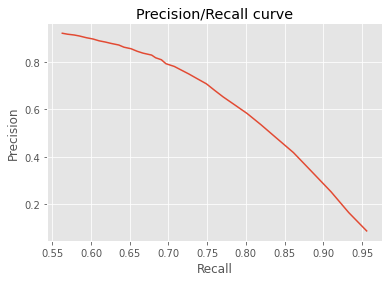

In [33]:
precs_mean = [i.mean() for i in precs]
recs_mean = [i.mean() for i in recs]
plt.style.use("ggplot")
plt.figure()
plt.plot(recs_mean, precs_mean)
plt.title("Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [39]:
print('threshold_value: precision  &  recall')
for threshold_id, threshold_value in enumerate(np.arange(0.02, 0.70, 0.02)):
    print(f'{threshold_value:.2f}:  {precs[threshold_id].mean():.2f}   {recs[threshold_id].mean():.2f}')

threshold_value: precision  &  recall
0.02:  0.09   0.96
0.04:  0.17   0.93
0.06:  0.25   0.91
0.08:  0.34   0.88
0.10:  0.42   0.86
0.12:  0.48   0.84
0.14:  0.53   0.82
0.16:  0.58   0.80
0.18:  0.62   0.78
0.20:  0.65   0.77
0.22:  0.68   0.76
0.24:  0.71   0.75
0.26:  0.73   0.74
0.28:  0.75   0.73
0.30:  0.77   0.72
0.32:  0.78   0.71
0.34:  0.79   0.70
0.36:  0.81   0.69
0.38:  0.82   0.68
0.40:  0.83   0.68
0.42:  0.84   0.67
0.44:  0.84   0.66
0.46:  0.85   0.65
0.48:  0.86   0.64
0.50:  0.87   0.64
0.52:  0.88   0.63
0.54:  0.88   0.62
0.56:  0.89   0.61
0.58:  0.90   0.60
0.60:  0.90   0.59
0.62:  0.91   0.58
0.64:  0.91   0.58
0.66:  0.92   0.57
0.68:  0.92   0.56
